## 1. Modules

In [1]:
# import basic modules
import pandas as pd
import warnings
import numpy as np
import os
import glob

In [2]:
# import all modules related to visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import style
from matplotlib.pyplot import plot
from matplotlib import pyplot
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [3]:
# import all modules related to statistical computing
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import q_stat, acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera

In [4]:
# filter warnings
warnings.filterwarnings("ignore")

## 2. Import Data

In [5]:
# read in all the csv-files
path = os.getcwd() + "/Model Data/Univariate"
files = glob.glob(os.path.join(path, "*.csv"))
file_list = list()
for f in files:
    df = pd.read_csv(f)
    file_list.append(df)

In [6]:
# set the date as index
for i in range(len(file_list)):
    file_list[i]["DATE"] = pd.to_datetime(file_list[i]["DATE"])
    file_list[i].set_index("DATE", inplace = True)

In [7]:
training, testing = [f for f in file_list]

## 3. Model Training (in-sample)

**Autoregressive Models:** In an autoregression model (AR), we forecast the variable of interest using a linear combination of past values of the variable. The term autoregression indicates that it is a regression of the variable against itself. Thus, an autoregressive model of order $p$ can be written as:

$$ \begin{aligned}
\text{AR(p) } : \;\; X_{t} &= c + \alpha_{1}X_{t-1} + \alpha_{2}X_{t-2} + \cdots + \alpha_{p}X_{t-p} + \epsilon_{t} \;\; \text{with} \;\; \epsilon_{t} \sim \mathcal{N}(0,\sigma^2) \\
&= c + \sum^{p}_{i=1}\alpha_{i}X_{t-i} + \epsilon_{t}
\end{aligned} $$

**Moving Average Models:** Rather than using past values of the forecast variable in a regression, a moving average model (MA) uses past forecast errors in a regression-like model:

$$ \begin{aligned}
\text{MA(q) } : \;\; X_{t} &= c + \beta_{1}\epsilon_{t-1} + \beta_{2}\epsilon_{t-2} + \cdots + \beta_{q}\epsilon_{t-q} + \epsilon_{t} \;\; \text{with} \;\; \epsilon_{t} \sim \mathcal{N}(0,\sigma^2) \\
&= c + \sum^{q}_{i=1}\beta_{i}\epsilon_{t-i} + \epsilon_{t}
\end{aligned} $$

**Autoregressive Integrated Moving Average Models:** An ARIMA model is a combination of an Autoregressive (AR) and a Moving Average model (MA), with the inclusion of differencing ability $(I)$. The general non-seasonal notation ARIMA(p,d,q) indicates a $p$ order of the AR part, $d$ degree of first differencing and $q$ order of the MA part. The term $\Delta^{d}X_{t}$ represents the differenced data.

$$
\text{ARIMA(p,d,q) } : \;\; \Delta^{d}X_{t} = c + \sum^{p}_{i=1}\alpha_{i}\Delta^{d}X_{t-i} + \sum^{q}_{j=1}\beta_{j}X_{t-j} + \epsilon_{t} \;\; \text{with} \;\; \epsilon_{t} \sim \mathcal{N}(0,\sigma^2)
$$

### 3.1 (Automated Version)

In [8]:
# in-sample forecast evaluation for arima models:
# 1. fit model parameters on the training sample and compute the aic
# 2. produce one-step-ahead forecasts for each value in the training sample
# 3. expand the sample to include the next observation, and repeat
# 4. compare fitted values against training sample
def evaluate_model(training, order):
    # fit model on training sample
    model = ARIMA(training, order = order)
    model_fit = model.fit()
    y_hat = model_fit.fittedvalues
    # save original data and fitted values
    model_data = training.copy()
    model_data["fitted_values"] = y_hat
    # compute the rmse for the given combination of (p,d,q)
    rmse = np.sqrt(mean_squared_error(training, y_hat))
    # return the rmse, fitted values, aic score and residuals
    return model_fit.aic, rmse, model_data, model_fit.resid

**Aikakes Information Criteria:** To determine which model will be utilized, we apply Aikakes Information Criteria (AIC), as this criterion suggests the optimal number of lags and parameters to be used in the model. AIC is based on information theory where a statistical representation of a given process will almost never be exact, and therefore AIC estimates the relative amount of information lost by a given model. The less information lost, the higher quality of a given model is attained.

$$ \text{AIC} = 2k - 2\ln(\hat{L}) $$

**Root Mean Squared Error:** To assess the model performance we use the Root Mean Squared Error (RMSE), which calculates the square of average differences between predicted and actual observations. RMSE can be calculated by:

$$ \text{RMSE} = \sqrt{\frac{1}{N}\sum^{N}_{i=1}(F_{t}-A_{t})^2} $$

### 3.2 (Manual Version)

In [9]:
"""
# split the training data into training and validation sets
def validation_split(data, ratio):
    training_size = int(len(data) * ratio)
    training, validation = data[0:training_size], data[training_size:]
    return training, validation
    
# 70% training data and 30% validation data
training, validation = validation_split(training, 0.7)

def evaluate_model(training, validation, order):
    history = [x for x in training.values]
    predictions = list()
    # iterate over each value in the validation set
    for t in range(len(validation.values)):
        # fit model on training sample
        model = ARIMA(history, order = order)
        model_fit = model.fit()
        # compute one-step-ahead forecast
        y_hat = model_fit.forecast()[0]
        # append prediction to list
        predictions.append(y_hat)
        # expand the training sample to include next observation and repeat
        history.append(validation.values[t])
    # compute rmse
    rmse = np.sqrt(mean_squared_error(validation, predictions))
    # save original data and fitted values
    model_data = validation.copy()
    model_data["prediction"] = predictions
    # return the rmse and the fitted values for a given combination of (p,d,q)
    return model_fit.aic, rmse, model_data, model_fit.resid
""";

### 3.3 Grid-Search

In [10]:
# grid-search for finding the best combination of arima parameters (p,d,q)
def grid_search(training, p_grid, d_grid, q_grid):
    best_score, best_cfg = float("inf"), None
    aic_values = list()
    for p in p_grid:
        for q in q_grid:
            for d in d_grid:
                order = (p,d,q)
                try:
                    aic, rmse, model_data, residuals = evaluate_model(training, order)
                    if aic < best_score:
                        best_score, best_rmse, best_cfg, best_model_data, best_resid = aic, rmse, order, model_data, residuals
                    print("> ARIMA%s; AIC = %.2f" % (order, aic))
                    aic_values.append(aic)
                except:
                    continue
    # print best model and return best configuration and best scores 
    print("> best model: ARIMA%s with AIC of %.2f" % (best_cfg, best_score))
    return best_cfg, best_model_data, aic_values, best_rmse, best_resid

In [11]:
# select range of (p,d,q) parameters
p, d, q = range(0,6), range(0,1), range(0,6)

In [12]:
# run the grid-search
best_cfg, model_data, aic_values, rmse, residuals = grid_search(training, p, d, q)

> ARIMA(0, 0, 0); AIC = 742.05
> ARIMA(0, 0, 1); AIC = 712.82
> ARIMA(0, 0, 2); AIC = 698.57
> ARIMA(0, 0, 3); AIC = 697.15
> ARIMA(0, 0, 4); AIC = 698.53
> ARIMA(0, 0, 5); AIC = 697.31
> ARIMA(1, 0, 0); AIC = 699.77
> ARIMA(1, 0, 1); AIC = 698.60
> ARIMA(1, 0, 2); AIC = 697.32
> ARIMA(1, 0, 3); AIC = 698.96
> ARIMA(1, 0, 4); AIC = 698.20
> ARIMA(1, 0, 5); AIC = 697.92
> ARIMA(2, 0, 0); AIC = 697.01
> ARIMA(2, 0, 1); AIC = 697.39
> ARIMA(2, 0, 2); AIC = 698.66
> ARIMA(2, 0, 3); AIC = 699.72
> ARIMA(2, 0, 4); AIC = 694.35
> ARIMA(2, 0, 5); AIC = 696.35
> ARIMA(3, 0, 0); AIC = 697.41
> ARIMA(3, 0, 1); AIC = 698.82
> ARIMA(3, 0, 2); AIC = 700.59
> ARIMA(3, 0, 3); AIC = 700.56
> ARIMA(3, 0, 4); AIC = 696.34
> ARIMA(3, 0, 5); AIC = 696.85
> ARIMA(4, 0, 0); AIC = 699.03
> ARIMA(4, 0, 1); AIC = 700.76
> ARIMA(4, 0, 2); AIC = 701.21
> ARIMA(4, 0, 3); AIC = 700.12
> ARIMA(4, 0, 4); AIC = 701.97
> ARIMA(4, 0, 5); AIC = 698.36
> ARIMA(5, 0, 0); AIC = 699.70
> ARIMA(5, 0, 1); AIC = 700.26
> ARIMA(

### 3.4 Model Visualization

In [13]:
# function for visualization of model training and the corresponding aic
def plot_model(model_data, aic, rmse):
    gs = gridspec.GridSpec(2, 2, height_ratios = [2, 1], width_ratios = [3, 1])
    plt.figure(figsize = (13,8))

    ax1 = plt.subplot(gs[0, 0])
    # plot actual and fitted values
    ax1.plot(model_data.iloc[:,0], color = "darkblue", label = "Actual")
    ax1.plot(model_data.iloc[:,1], color = "red", label = "Fitted", linestyle = "-")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Real GDP Growth")
    ax1.set_title("Fitted Values for best ARIMA Combination (RMSE = %.2f)" % (rmse), loc = "left")
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    ax1.legend(frameon = False)

    ax2 = plt.subplot(gs[0, 1])
    # plot aic values
    ax2.plot(aic, color = "green")
    ax2.set_xlabel("Grid-Search Iteration")
    ax2.set_ylabel("AIC Value")
    ax2.set_title("Corresponding AIC", loc = "left")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")

    ax3 = plt.subplot(gs[1, :])
    # plot actual and fitted values (yearly average)
    ax3.plot(model_data.iloc[:,0].resample("Y").mean(), color = "darkblue", 
             label = "Actual")
    ax3.plot(model_data.iloc[:,1].resample("Y").mean(), color = "red", 
             label = "Fitted", linestyle = "-")
    ax3.set_title("Fitted Values (Yearly Average)", loc = "left")
    ax3.set_xlabel("Date")
    ax3.set_ylabel("Real GDP Growth")
    ax3.tick_params(direction = "in")
    ax3.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    ax3.legend(frameon = False)
    
    # layout optimization
    plt.tight_layout()

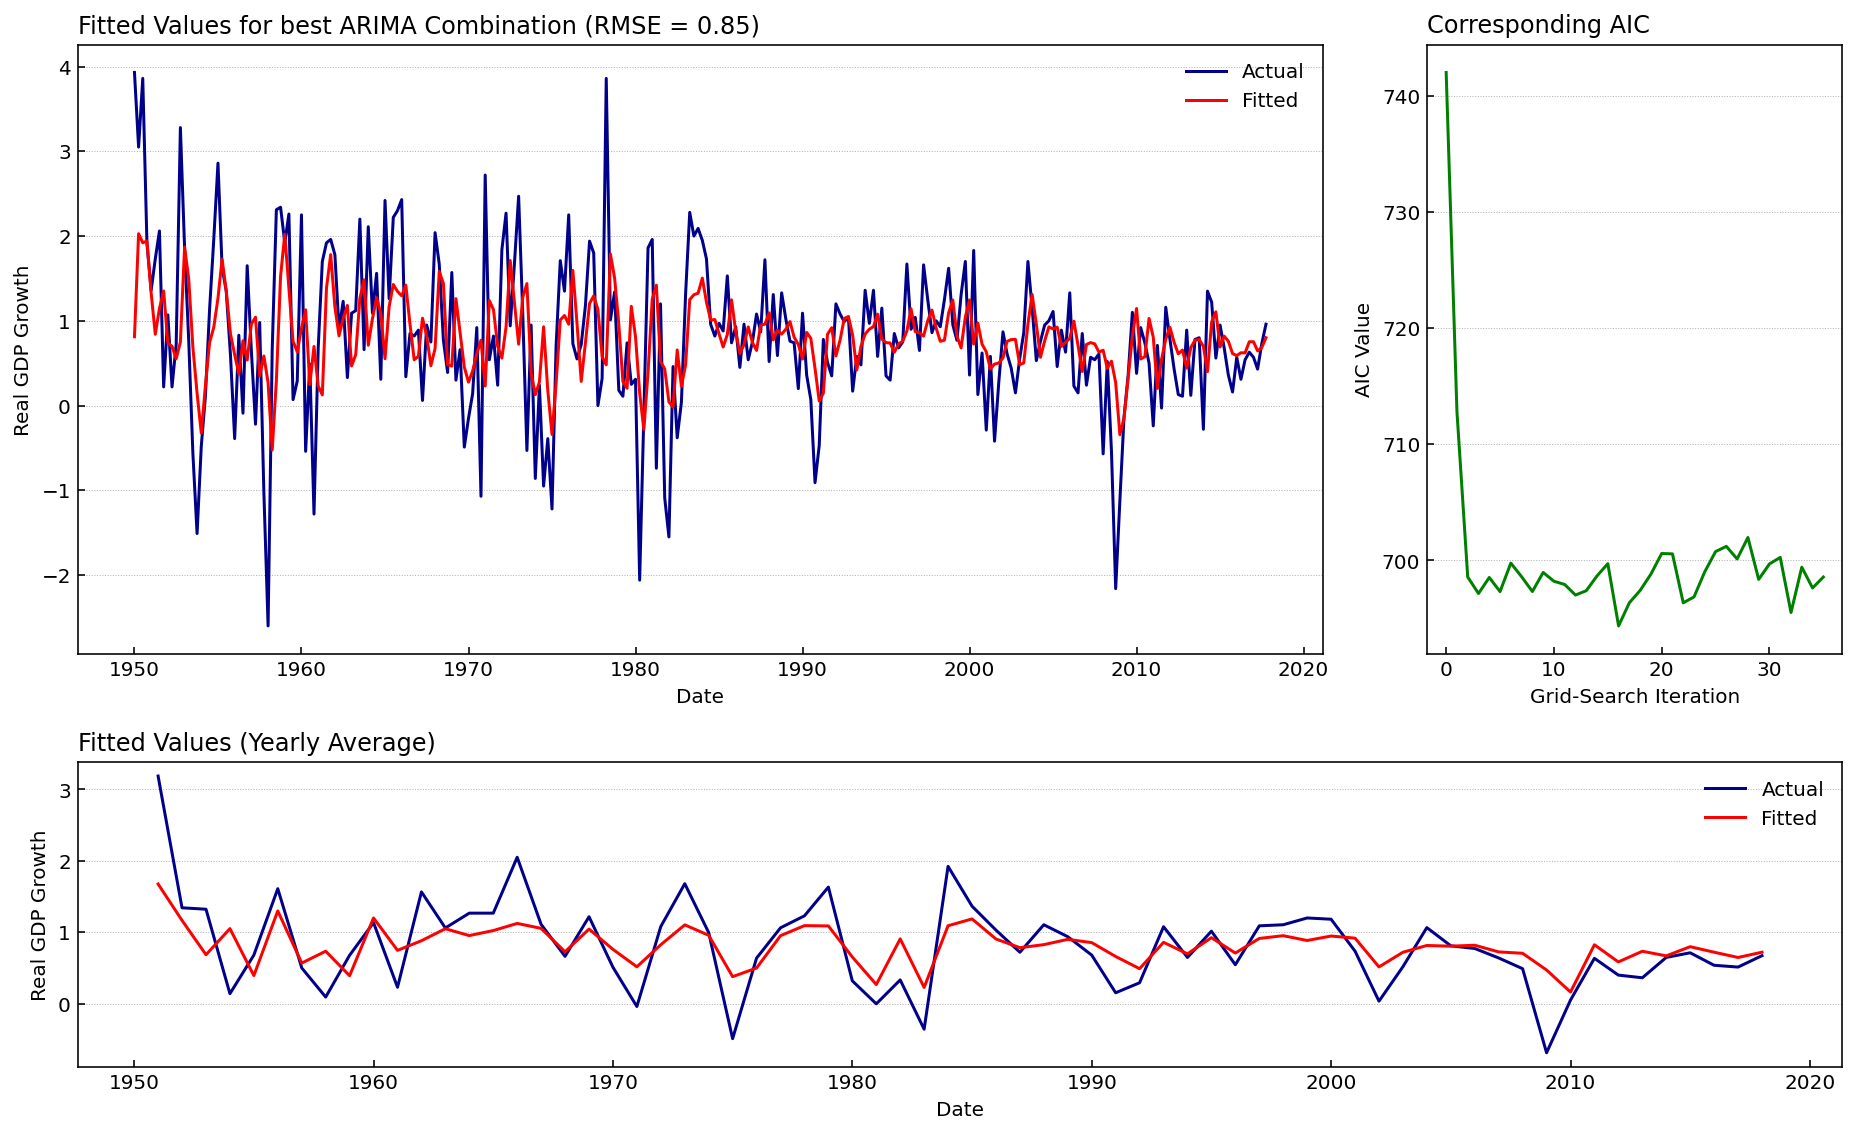

In [14]:
# visualize the model training
plot_model(model_data, aic_values, rmse)

## 4. Residual Diagnostics

In [15]:
# good forecasting methods will yield residuals with the following properties:
# 1. The residuals are uncorrelated (otherwise there is information left)
# 2. The residuals have zero mean (otherwise the forecasts are biased)
# 3. The residuals have constant variance (useful, but not necessary)
# 4. The residuals are normally distributed (useful, but not necessary)
def plot_residuals(data):   
    gs = gridspec.GridSpec(2, 2, height_ratios = [2, 1])
    plt.figure(figsize = (13,8))

    ax1 = plt.subplot(gs[0, 0])
    # distribution plot
    residuals.plot(kind = "density", ax = ax1, color = "darkblue", legend = False)
    ax1.set_title("Density of Residuals", loc = "left")
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    # normal distribution
    mean, std = stats.norm.fit(residuals)
    x = np.linspace(-8, 8, 300)
    p = stats.norm.pdf(x, mean, std)
    ax1.plot(x, p, "green")
    ax1.legend(["Residuals", "Normal"], frameon = False)
    ax1.axvline(x = 0, color = "red", linestyle = "--")

    ax2 = plt.subplot(gs[0, 1])
    # compute the autocorrelation coefficients of the residuals and plot them
    plot_acf(residuals, ax = ax2, title = "", zero = False, color = "darkblue", 
             alpha = None, lags = 50, use_vlines = True, vlines_kwargs = {"colors": "darkblue"})
    ax2.axhline(y = 2 / np.sqrt(len(residuals)), color = "red", linestyle = "--")
    ax2.axhline(y = -2 / np.sqrt(len(residuals)), color = "red", linestyle = "--")
    ax2.set_title("Autocorrelation Function of Residuals", loc = "left")
    ax2.set_ylim(-0.25, 0.25)
    ax2.set_xlabel("Lags")
    ax2.set_ylabel("Autocorrelation")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")

    ax3 = plt.subplot(gs[1, :])
    # plot actual and fitted values on yearly average
    ax3.plot(residuals, color = "darkblue")
    ax3.axhline(y = 0, color = "red", linestyle = "--")
    ax3.set_title("Residuals", loc = "left")
    ax3.set_xlabel("Date")
    ax3.tick_params(direction = "in")
    ax3.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    # layout optimization
    plt.tight_layout()

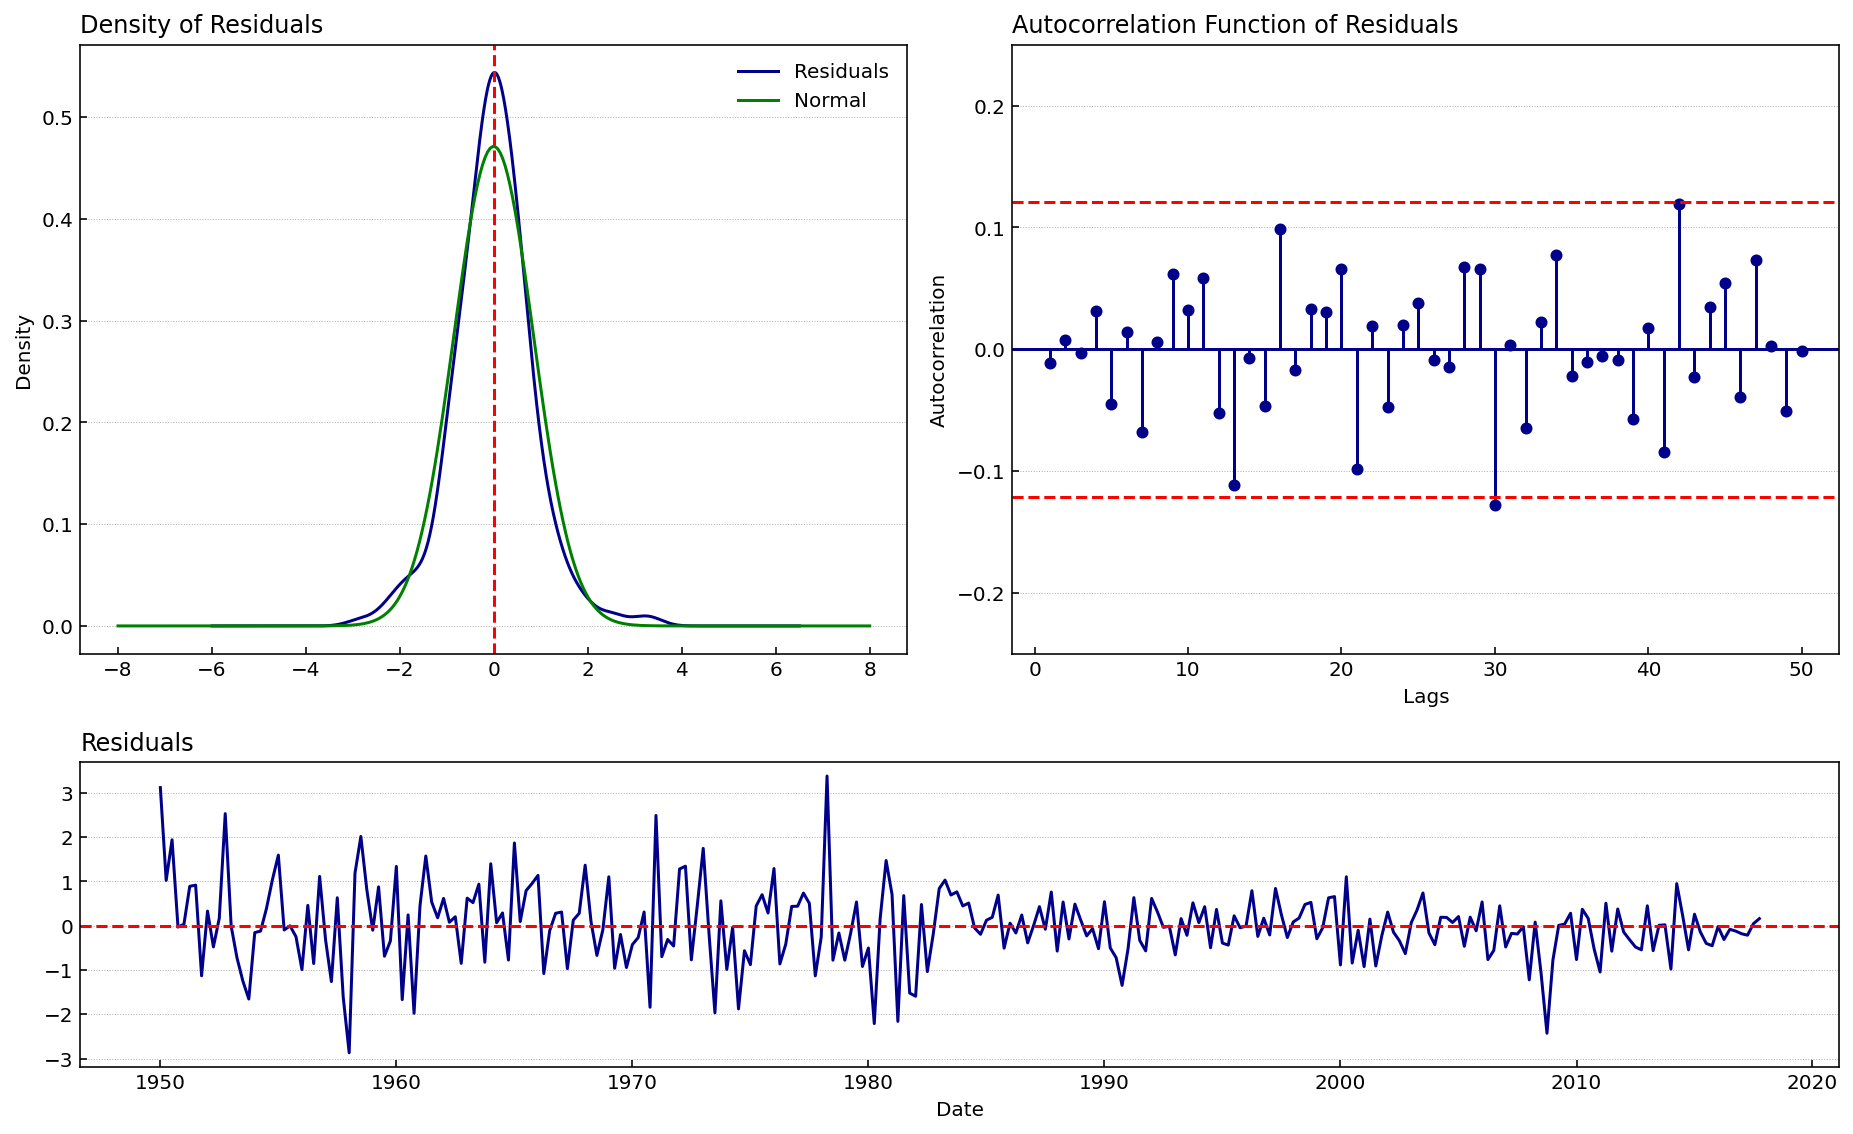

In [16]:
# residuals for chosen parameter combination on full training data
plot_residuals(residuals)

### 4.1 Goldfeld-Quandt Test for Heteroskedasticity

In [17]:
# source code from statsmodels for Goldfeld-Quandt test
def heteroskedasticity_test(resid):
    squared_resid = np.asarray(resid, dtype = float) ** 2
    if squared_resid.ndim == 1:
        squared_resid = squared_resid.reshape(-1, 1)
    nobs = len(resid)

    h = int(np.round(nobs * 1/3))

    numer_resid = squared_resid[-h:]
    numer_dof = (~np.isnan(numer_resid)).sum(axis = 0)
    numer_squared_sum = np.nansum(numer_resid, axis = 0)

    denom_resid = squared_resid[:h]
    denom_dof = (~np.isnan(denom_resid)).sum(axis = 0)
    denom_squared_sum = np.nansum(denom_resid, axis = 0)

    test_statistic = numer_squared_sum / denom_squared_sum

    from scipy.stats import f
    pval_lower = lambda test_statistics: f.cdf(test_statistics, numer_dof, denom_dof)
    pval_upper = lambda test_statistics: f.sf(test_statistics, numer_dof, denom_dof)
    p_value = 2 * np.minimum(pval_lower(test_statistic), pval_upper(test_statistic))

    return test_statistic, p_value

In [18]:
# Goldfeld-Quandt test
# null hypothesis : homoscedasticity of residuals (constant variance)
# alternate hypothesis : heteroscedasticity of residuals (variance not constant)
# reject null hypothesis if p-value <= 0.05
def gq_test(data):
    gq_test = heteroskedasticity_test(data)
    test_statistic, p_value = gq_test[0], gq_test[1]
    print("> goldfeld-quandt test results:")
    print("> test statistic = %.2f" % (test_statistic))
    print("> p-value = %.2f" % (p_value))

$$ \text{Goldfeld-Quandt Test Statistic:} \;\; F = \frac{S^2_{1}}{S^2_{2}} \;\; \text{with} \;\; S^2_{i} = \frac{1}{n_{i}-k}\sum^{n_{i}}_{j=1}\epsilon^2_{ij} $$

In [19]:
gq_test(residuals)

> goldfeld-quandt test results:
> test statistic = 0.27
> p-value = 0.00


### 4.2 Ljung-Box-Q Test for Autocorrelation

In [20]:
# Ljung-Box-Q test
# null hypothesis : data is independently distributed (no autocorrelation)
# alternate hypothesis : data is not independently distributed
# reject null hypothesis if p-value <= 0.05
def lbq_test(data):
    lbq_test = acorr_ljungbox(data)
    test_statistic, p_value = lbq_test[0].mean(), lbq_test[1].mean()
    print("> ljung-box test results:")
    print("> average test statistic = %.2f" % (test_statistic))
    print("> average p-value = %.2f" % (p_value))

$$ \text{Ljung-Box-Q Test Statistic :} \;\; Q(m) = n(n+2)\sum^{m}_{h=1}\frac{\hat{\varrho}_{h}^2}{n-h} $$

In [21]:
lbq_test(residuals)

> ljung-box test results:
> average test statistic = 15.15
> average p-value = 0.83


### 4.3 Jarque-Bera Test for Normality

In [22]:
# Jarque-Bera test
# null hypothesis : data is normally distributed
# alternate hypothesis : data is not normally distributed
# reject null hypothesis if p-value <= 0.05
def jb_test(data):
    jb_test = jarque_bera(data)
    test_statistic, p_value, skew, kurtosis = jb_test[0], jb_test[1], jb_test[2], jb_test[3]
    print("> jarque-bera test results:")
    print("> test statistic = %.2f" % (test_statistic))
    print("> p-value = %.2f" % (p_value))
    print("> estimated skew = %.2f" % (skew))
    print("> estimated kurtosis = %.2f" % (kurtosis))

$$ \text{Jarque-Bera Test Statistic:} \;\; JB = \frac{N}{6}\left( v^2 + \frac{w^2}{4} \right) $$

In [23]:
jb_test(residuals)

> jarque-bera test results:
> test statistic = 44.98
> p-value = 0.00
> estimated skew = 0.22
> estimated kurtosis = 4.94


## 5. Forecasting (out-of-sample)

In [24]:
history = [x for x in training.values]
predictions = list()
ci_lower = list()
ci_upper = list()
# walk-forward validation
for t in range(len(testing.values)):
    model = ARIMA(history, order = best_cfg)
    model_fit = model.fit()
    # compute forecast with 80% confidence interval
    y_hat = model_fit.get_forecast().summary_frame(alpha = 0.2)
    predictions.append(y_hat["mean"][0])
    ci_lower.append(y_hat["mean_ci_lower"][0])
    ci_upper.append(y_hat["mean_ci_upper"][0])
    history.append(np.asarray([y_hat["mean"][0]]))
    date = str.split(str(testing.index[t]))[0]
    print("> (%s) forecasted = %.2f; actual = %.2f" % (date, y_hat["mean"][0], testing.values[t]))
# evaluate forecasts using rmse
rmse = np.sqrt(mean_squared_error(testing.values, predictions))
# save original data and predicted values
forecast_data = testing.copy()
forecast_data["prediction"] = predictions
forecast_data["mean_ci_lower"] = ci_lower
forecast_data["mean_ci_upper"] = ci_upper

> (2018-01-01) forecasted = 0.85; actual = 0.93
> (2018-04-01) forecasted = 0.85; actual = 0.67
> (2018-07-01) forecasted = 0.86; actual = 0.53
> (2018-10-01) forecasted = 0.80; actual = 0.33
> (2019-01-01) forecasted = 0.77; actual = 0.73
> (2019-04-01) forecasted = 0.83; actual = 0.37
> (2019-07-01) forecasted = 0.84; actual = 0.64
> (2019-10-01) forecasted = 0.78; actual = 0.59


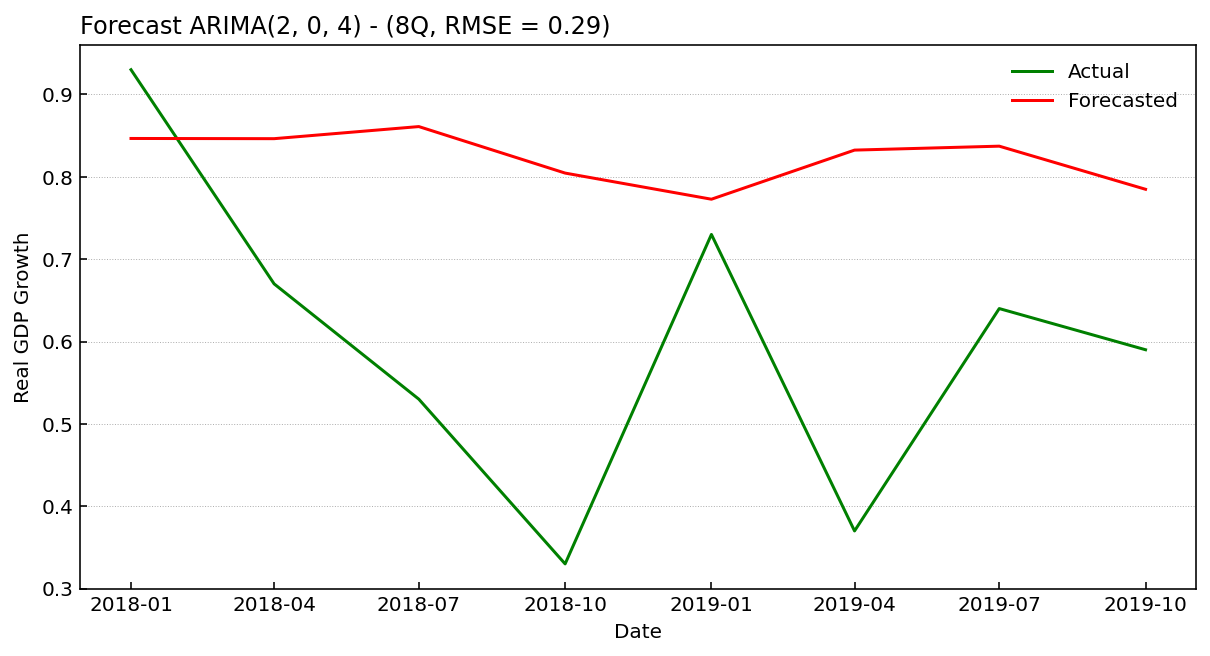

In [25]:
plt.figure(figsize = (10,5))
plt.plot(forecast_data.iloc[:,0], color = "green", label = "Actual")
plt.plot(forecast_data.iloc[:,1], color = "red", label = "Forecasted")
# plt.fill_between(forecast_data.index, forecast_data["mean_ci_lower"], forecast_data["mean_ci_upper"], 
#                 color = "k", alpha = 0.1, label = r"CI ($\alpha = 0.2$)")
plt.xlabel("Date")
plt.ylabel("Real GDP Growth")
plt.title("Forecast ARIMA%s - (8Q, RMSE = %.2f)" % (best_cfg, rmse), loc = "left")
plt.tick_params(direction = "in")
plt.grid(axis = "y", linewidth = 0.5, linestyle = ":")
plt.legend(frameon = False)
plt.show()